In [28]:
#libraries required
#Data preprocessing
import numpy as np 
import pandas as pd 
import os
import glob
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()
import random





In [4]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")

In [5]:
train_df.head() #the first 5 samples of the dataframe

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [6]:
train_df.tail() #the last 5 samples of the dataframe

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0
106799,351917269,10,20.0,2147388374,10,20.0,3642716176,10351,LRDA,0,0,0,3,0,0


In [7]:
train_df.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,1.068000e+05,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000,106800.000000
mean,2.104387e+09,26.286189,118.817228,1.067262e+09,43.733596,520.431404,2.141415e+09,32304.428493,0.878024,1.138783,1.264925,0.948296,1.059185,1.966283
std,1.233371e+09,69.757658,314.557803,6.291475e+08,104.292116,1449.759868,1.241670e+09,18538.196252,1.538873,2.818845,3.131889,2.136799,2.228492,3.621180
min,5.686570e+05,0.000000,0.000000,3.537330e+05,0.000000,0.000000,3.380000e+02,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.026896e+09,1.000000,6.000000,5.238626e+08,2.000000,12.000000,1.067419e+09,16707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.071326e+09,5.000000,26.000000,1.057904e+09,8.000000,62.000000,2.138332e+09,32068.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.172787e+09,16.000000,82.000000,1.623195e+09,29.000000,394.000000,3.217816e+09,48036.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
max,4.294958e+09,742.000000,3372.000000,2.147388e+09,1021.000000,17632.000000,4.294934e+09,65494.000000,19.000000,18.000000,16.000000,15.000000,15.000000,25.000000


In [8]:
train_df.shape[0]

106800

In [9]:
unique_eeg_id = train_df['eeg_id'].nunique()
print("Unique eeg ids:", unique_eeg_id)
unique_spec_id = train_df['spectrogram_id'].nunique()
print("Unique spec ids:", unique_spec_id)

Unique eeg ids: 17089
Unique spec ids: 11138


### Using EEG-id and spectogram-id, integrating their file paths with train-df

In [10]:
#Function to extract the file paths using ids. 
def create_id_mapping(paths_list):
    id_map = {}
    for path in paths_list:
        file_id = os.path.basename(path).split('.')[0]  
        id_map[file_id] = path
    return id_map

def mapping_id(ids, id_map):
    return id_map.get(ids)

In [11]:
# extracting the eeg, spectogram paths from parent files.
train_eeg_path = glob.glob("/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/*")
train_spectrograms_path = glob.glob("/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/*")
eeg_id_map = create_id_mapping(train_eeg_path) 
spectrograms_id_map = create_id_mapping(train_spectrograms_path)

#mapping through all the ids. 
print("Mapping train_eeg_path:")
train_df['eeg_path'] = train_df['eeg_id'].astype(str).progress_apply(lambda x: mapping_id(x, eeg_id_map))

print("Mapping train_spectrograms_path:")
train_df['spectrograms_path'] = train_df['spectrogram_id'].astype(str).progress_apply(lambda x: mapping_id(x, spectrograms_id_map))

Mapping train_eeg_path:


100%|██████████| 106800/106800 [00:00<00:00, 494650.65it/s]


Mapping train_spectrograms_path:


100%|██████████| 106800/106800 [00:00<00:00, 490944.67it/s]


In [12]:
train_df.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spectrograms_path
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...


In [13]:
train_df.shape[0]

106800

### Using EEG-id and spectogram-id, integrating their file paths with test-df

In [14]:
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")

# extracting the eeg, spectogram paths from parent files.
test_eeg_path = glob.glob("/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/*")
test_spectrograms_path = glob.glob("/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/*")
eeg_id_map = create_id_mapping(test_eeg_path)
spectrograms_id_map = create_id_mapping(test_spectrograms_path)

# #mapping through all the ids. 
print("Mapping test_eeg_path:")
test_df['eeg_path'] = test_df['eeg_id'].astype(str).progress_apply(lambda x: mapping_id(x, eeg_id_map))

print("Mapping test_spectrograms_path","-"*60)
test_df['spectrograms_path'] = test_df['spectrogram_id'].astype(str).progress_apply(lambda x: mapping_id(x, spectrograms_id_map))

Mapping test_eeg_path:


100%|██████████| 1/1 [00:00<00:00, 1804.78it/s]


Mapping test_spectrograms_path ------------------------------------------------------------


100%|██████████| 1/1 [00:00<00:00, 2113.00it/s]


In [15]:
test_df

,spectrogram_id,eeg_id,patient_id,eeg_path,spectrograms_path
0,853520,3911565283,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...


### Understanding Parquet files

In [16]:
parquet_path = train_df['spectrograms_path'][1]
spec_df = pd.read_parquet(parquet_path)

print("Reading parquet file", spec_df)

Reading parquet file      time  LL_0.59  LL_0.78  LL_0.98  LL_1.17  LL_1.37    LL_1.56    LL_1.76  \
0       1     4.26    10.98     9.05    13.65    11.49   8.930000  18.840000   
1       3     2.65     3.97    12.18    13.26    14.21  13.230000   9.650000   
2       5     4.18     4.53     8.77    14.26    13.36  16.559999  19.219999   
3       7     2.41     3.21     4.92     8.07     5.97  12.420000  10.820000   
4       9     2.29     2.44     2.77     4.62     5.39   7.080000   9.840000   
..    ...      ...      ...      ...      ...      ...        ...        ...   
315   631     6.36     6.59     6.60     7.30     4.48   8.400000  13.420000   
316   633     4.90     8.80     8.22     5.83    10.21  10.580000  10.250000   
317   635     6.07     7.85    11.26     9.20     8.18   9.130000  10.450000   
318   637     3.41     3.75     4.80     6.45     6.70   7.960000   8.160000   
319   639     2.88     3.71     4.02     6.07     5.63   5.460000   6.270000   

     LL_1.95    LL

In [20]:
# Process the DataFrame to convert it into a numpy array
spec_array = spec_df.fillna(0).values[:, 1:].T  # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
spec_array = spec_array.astype("float32")
print("spec_array:", spec_array)
print("shape of spec_array: ", spec_array.shape)
#we have performed frequency transform and can observe the 
#change in dimensions of the spectrogram (320 x 400) --> (400 X 320)

spec_array: [[ 4.26  2.65  4.18 ...  6.07  3.41  2.88]
 [10.98  3.97  4.53 ...  7.85  3.75  3.71]
 [ 9.05 12.18  8.77 ... 11.26  4.8   4.02]
 ...
 [ 0.16  0.31  0.48 ...  0.09  0.16  0.09]
 [ 0.22  0.36  0.44 ...  0.17  0.19  0.07]
 [ 0.19  0.4   0.48 ...  0.12  0.19  0.05]]
shape of spec_array:  (400, 320)


#### Defining Parquet to nummpy file function

In [21]:
def parquet_to_numpy(parquet_path):
    # Read the Parquet file into a DataFrame
    spec_df = pd.read_parquet(parquet_path)
    
    # Process the DataFrame to convert it into a numpy array
    spec_array = spec_df.fillna(0).values[:, 1:].T  # fill NaN values with 0, transpose for (Time, Freq) -> (Freq, Time)
    spec_array = spec_array.astype("float32")
    
    return spec_array

### Data preprocessing


In [22]:
def preprocess_spectrogram(image_array):

    # Normalization: To reduce the computational stress
    
    image_array = image_array.astype('float32')
    image_array -= np.min(image_array)
    image_array /= np.max(image_array) + 1e-4
    
    #Log Transformation: Boosts contrast while lessening the impact of anomalies.
    #It facilitates improved spectrogram feature visualization.

    image_array = np.log(image_array + 1e-4)
    
    # Mean Subtraction: Centers the data around zero
    # This improves the stability of model by reducing the bias
    mean = np.mean(image_array)
    image_array -= mean
    
    # Standardization: Scales the data to have zero mean and unit variance
    # It ensures that every feature has a comparable scale, it can enhance the performance of the model.
    std = np.std(image_array)
    image_array /= std + 1e-6
    
    return image_array

## Creating Train And Test Data Directory

In [23]:
#these directories are used to stores train and test data in later stage
current_dir = os.getcwd()
train_dir = os.path.join(current_dir, "train")
test_dir  = os.path.join(current_dir, "test")
print("train_dir--->", train_dir)
print("test_dir---->", test_dir)
os.makedirs(train_dir, exist_ok = True)
os.makedirs(test_dir, exist_ok = True)

train_dir---> /kaggle/working/train
test_dir----> /kaggle/working/test


### Loading Train Spectograms Data To Train Dir path

In [46]:
from PIL import Image

for i in tqdm(train_df['spectrograms_path'].unique()):
    # convert the parquet to numpy then apply the preprocessing on the images in numpy format
    img_array = preprocess_spectrogram(parquet_to_numpy(i))

    img_name = os.path.basename(i).split('.')[0] + ".jpeg"
    spectrograms_path = os.path.join(train_dir, "spectrograms")
    os.makedirs(spectrograms_path, exist_ok=True)
    
    plt.imsave(os.path.join(spectrograms_path, img_name), img_array)

100%|██████████| 11138/11138 [06:44<00:00, 27.52it/s]


### Loading Test Spectograms Data To Test Dir path

In [25]:
from PIL import Image

for i in tqdm(test_df['spectrograms_path'].unique()):
    img_array = preprocess_spectrogram(parquet_to_numpy(i))

    img_name = os.path.basename(i).split('.')[0] + ".jpeg"
    spectrograms_path = os.path.join(test_dir, "spectrograms")
    os.makedirs(spectrograms_path, exist_ok=True)
    
    plt.imsave(os.path.join(spectrograms_path, img_name), img_array)

100%|██████████| 1/1 [00:00<00:00, 19.34it/s]


In [33]:
train_df["spectrogram_id"].nunique()

11138

In [58]:

x = train_df['spectrograms_path expert_consensus'.split()].drop_duplicates().reset_index(drop = True)
#creates a dictionary where each 'spectrograms_path'
#from the DataFrame is a key, and the corresponding 'expert_consensus' value is the value in the dictionary. 
dict_x = dict(zip(x['spectrograms_path'], x['expert_consensus']))

In [59]:
for original_path in tqdm(glob.glob("/kaggle/working/train/spectrograms/*")):
    # Extract the image ID from the file name
    img_id = os.path.basename(original_path).split('.')[-2]
    # Find the corresponding value in dict_x based on the image ID
    x = [v for k, v in dict_x.items() if img_id in k][0]
    
    # Construct the new file name with the same directory path
    directory_path = os.path.dirname(original_path)
    new_filename = f"{x}.{img_id}.jpeg"
    
    # Construct the new file path
    new_path = os.path.join(directory_path, new_filename)
    
    # Rename the file
    os.rename(original_path, new_path)

100%|██████████| 11138/11138 [00:17<00:00, 653.96it/s]


In [60]:


# Get a list of all files in the folder
file_list = glob.glob("/kaggle/working/train/spectrograms/*")

# Get the number of files in the folder
num_files = len(file_list)

print("Number of files in the folder:", num_files)

# Choose 5 random files from the list
random_files = random.sample(file_list, 5)

# Print the random files
for file_path in random_files:
    print(file_path)

Number of files in the folder: 11138
/kaggle/working/train/spectrograms/Other.756444434.jpeg
/kaggle/working/train/spectrograms/Other.1624268583.jpeg
/kaggle/working/train/spectrograms/Other.998417285.jpeg
/kaggle/working/train/spectrograms/GRDA.971936465.jpeg
/kaggle/working/train/spectrograms/Seizure.1885651184.jpeg


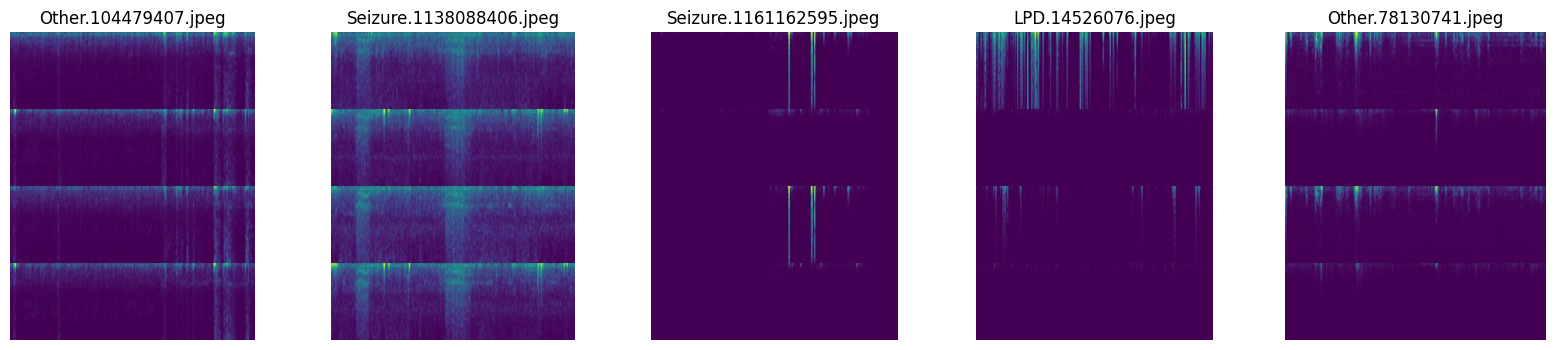

In [61]:
import os
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

# Get a list of all files in the folder
file_list = glob.glob("/kaggle/working/train/spectrograms/*")

# Choose 5 random files from the list
random_files = random.sample(file_list, 5)

# Plot the random files
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, file_path in enumerate(random_files):
    img = Image.open(file_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(os.path.basename(file_path))
plt.show()


In [63]:
# Find the count of unique combinations of eeg_id and spectrogram_id and expert_consensus
u = train_df.groupby(['eeg_id', 'spectrogram_id', 'expert_consensus']).size().shape[0]
u

18013

### So we will create a train set which unique combination of eeg_id, spectrogram_id and expert_consensus.

In [64]:
def create_id_mapping(paths_list):
    id_map = {}
    for path in paths_list:
        file_id = os.path.basename(path).split('.')[1]  # Corrected to extract the file ID correctly
        id_map[file_id] = path
    return id_map

def mapping_id(ids, id_map):
    return id_map.get(ids)

In [65]:
# Create ID mappings for train_eeg_path_list and train_spectrograms_path_list
train_spectrograms_path_list = glob.glob("/kaggle/working/train/spectrograms/*")
spectrograms_id_map = create_id_mapping(train_spectrograms_path_list)

train_df = train_df['eeg_id spectrogram_id expert_consensus'.split()].drop_duplicates().reset_index(drop = True)

train_df['spectrograms_path'] = train_df['spectrogram_id'].astype(str).progress_apply(lambda x: mapping_id(x, spectrograms_id_map))

100%|██████████| 18013/18013 [00:00<00:00, 448678.04it/s]


In [66]:
train_df.shape

(18013, 4)

### Class Distribution

In [67]:
train_df['expert_consensus'].value_counts()

expert_consensus
Other      7427
Seizure    3011
LPD        2774
GRDA       1892
GPD        1869
LRDA       1040
Name: count, dtype: int64

### The dataset is imbalanced

In [68]:
train_df.head(3)

,eeg_id,spectrogram_id,expert_consensus,spectrograms_path
0,1628180742,353733,Seizure,/kaggle/working/train/spectrograms/Seizure.353...
1,2277392603,924234,GPD,/kaggle/working/train/spectrograms/GPD.924234....
2,722738444,999431,LRDA,/kaggle/working/train/spectrograms/LRDA.999431...


### Trainv - Validation Split

In [69]:
#we will split the dataset in 80:20 ratio
from sklearn.model_selection import train_test_split
train_dataset, valid_dataset = train_test_split(train_df ,test_size = 0.2 , random_state = 42, shuffle = True,
                                               stratify = train_df['expert_consensus'])

In [72]:
print("shape of train set:", train_dataset.shape)
print("shape of val set:", valid_dataset.shape)

shape of train set: (14410, 4)
shape of val set: (3603, 4)


In [128]:
#Deep learning tensorflow
#libraries used
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow import keras 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
import sklearn
import tensorflow.keras.optimizers as keras_optimizers
from sklearn.metrics import roc_auc_score, balanced_accuracy_score


import tensorflow as tf


In [75]:
#since the images are of spectrograms(sensitive data), we are not 
#applying any augmentation techniques because that 
#could result in misinformation
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()


In [76]:
training_set = train_datagen.flow_from_dataframe(
                        dataframe = train_dataset,
                        x_col = 'spectrograms_path',
                        y_col = 'expert_consensus',
                        target_size=(256,256),
                        color_mode='rgb',
                        class_mode = 'categorical',
                        batch_size= 32)

validation_set = test_datagen.flow_from_dataframe(
                dataframe = valid_dataset,
                x_col = 'spectrograms_path',
                y_col = 'expert_consensus',
                color_mode='rgb',
                target_size = (256, 256),
                class_mode = 'categorical',
                batch_size = 32)

Found 14410 validated image filenames belonging to 6 classes.
Found 3603 validated image filenames belonging to 6 classes.


### ResNet 50

In [94]:
img_height, img_width = (256,256)

IMG_SHAPE = (img_height,img_width,3)
def create_model():

  R50_model = ResNet50(include_top = False, weights='imagenet',input_shape = IMG_SHAPE)
  layer = tf.keras.layers.Dropout(0.30)
    #we set include_top = false coz we want to train resnet on our set
    #target classes

  x = R50_model.output
#taking the top layer of Resnet50 and connecting with dense layers
  x = GlobalAveragePooling2D()(x)

  x = Dense(1024, activation='relu')(x)
  x = layer(x)
  
  predictions = Dense(6, activation='softmax')(x)
  model = Model(inputs=R50_model.input, outputs=predictions)

  for layer in R50_model.layers:
    layer.trainable = False
    
  opt = keras.optimizers.Adam(learning_rate=0.0001)#learning rate as 10^-4
  model.compile(loss='categorical_crossentropy', optimizer=opt,
               metrics = ['accuracy','mse'])

  #model.compile(optimizer='adam', loss='categorical_crossentropy', 
            #   metrics = ['accuracy','mse'])
 # model.fit(train_generator, epochs = 10)
  return model

model = create_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [99]:
# 20 epochs for Resnet50 model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger




#Dynamic learning rate: 
#Reduce learning rate when a metric has stopped improving.

#from reducing the learning rate by a factor of 2
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_accuracy', patience=4,
                              verbose=0, restore_best_weights=True)



# Train the model with the new callback
model_history = model.fit(training_set, epochs = 20,callbacks=[early_stopper, reduce_lr],
                          validation_data=validation_set, verbose = 1, shuffle = True)
          

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/451 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.2031 - loss: 2.2725 - mse: 0.1623   

I0000 00:00:1714347943.689325      95 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4119 - loss: 1.6493 - mse: 0.1274

W0000 00:00:1714348007.311584      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


451/451 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.4120 - loss: 1.6489 - mse: 0.1274 - val_accuracy: 0.5390 - val_loss: 1.2175 - val_mse: 0.0998 - learning_rate: 1.0000e-04
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.5437 - loss: 1.2191 - mse: 0.1003 - val_accuracy: 0.5587 - val_loss: 1.1687 - val_mse: 0.0965 - learning_rate: 1.0000e-04
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - accuracy: 0.5769 - loss: 1.1254 - mse: 0.0934 - val_accuracy: 0.5817 - val_loss: 1.1405 - val_mse: 0.0935 - learning_rate: 1.0000e-04
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 106ms/step - accuracy: 0.5923 - loss: 1.0727 - mse: 0.0897 - val_accuracy: 0.5823 - val_loss: 1.1058 - val_mse: 0.0917 - learning_rate: 1.0000e-04
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.6151 - loss: 1.0256 - mse: 0.0862 - val_accuracy: 0.5909 - val_loss: 1.1000 - val_mse: 0.0908 - learning_rate: 1.0000e-04
Epoch 6/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 85s 108ms/step -

In [100]:
model.save('/kaggle/working/resnet50.h5')

Epoch vs accuracy/ Epoch Vs Loss

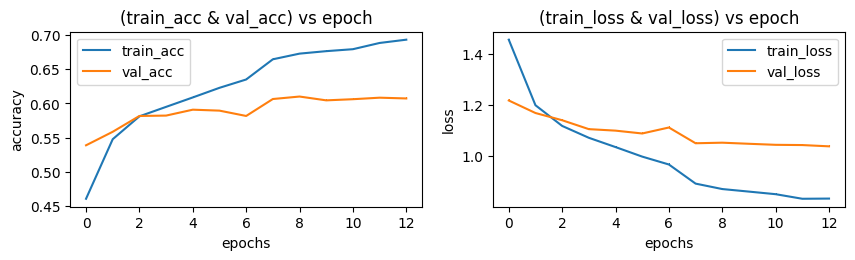

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [101]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()


In [131]:
model_1 = tensorflow.keras.models.load_model('/kaggle/working/resnet50.h5')

In [114]:
evaluation = model_1.evaluate(validation_set)

# Print the evaluation metrics
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.6161 - loss: 1.0497 - mean_squared_error: 0.0867
Loss: 1.0530223846435547
Accuracy: 0.6100471615791321


W0000 00:00:1714349629.706602      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Confusion Matrix 

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 106ms/step


W0000 00:00:1714351189.722972      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


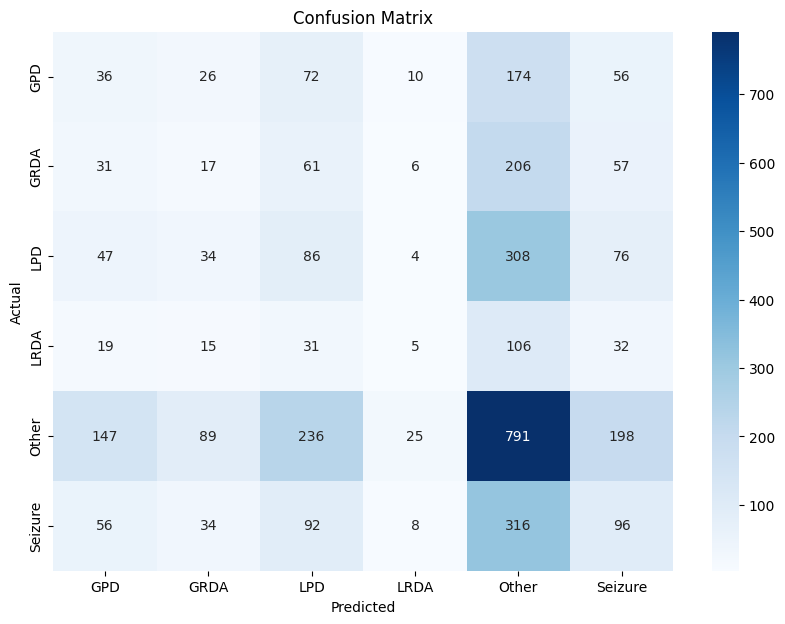

In [132]:

predictions = model_1.predict(validation_set)
predicted_classes = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(validation_set.labels, predicted_classes)


labels = list(validation_set.class_indices.keys())
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [116]:
print(classification_report(validation_set.labels, predicted_classes, target_names=list(validation_set.class_indices.keys())))

              precision    recall  f1-score   support

         GPD       0.11      0.10      0.10       374
        GRDA       0.12      0.07      0.09       378
         LPD       0.16      0.16      0.16       555
        LRDA       0.05      0.01      0.02       208
       Other       0.41      0.52      0.46      1486
     Seizure       0.15      0.13      0.14       602

    accuracy                           0.28      3603
   macro avg       0.17      0.17      0.16      3603
weighted avg       0.24      0.28      0.26      3603



In [133]:
balanced_acc = balanced_accuracy_score(validation_set.labels, predicted_classes)
print("Balanced accuracy: ", balanced_acc)

Balanced accuracy:  0.16866559416361138


### EfficientB0

Model Building

In [119]:



def create_model():
    efficient_net = EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
    layer = Dropout(0.30)
    
    x = efficient_net.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = layer(x)
    
    predictions = Dense(6, activation='softmax')(x)
    model = Model(inputs=efficient_net.input, outputs=predictions)

    for layer in efficient_net.layers:
        layer.trainable = False

    opt = keras_optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'mse'])

    return model

model = create_model()
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 256, 256,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 256, 256,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 256, 256,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 5,367,465 (20.48 MB)

 Trainable params: 1,317,894 (5.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Model Compilation

In [120]:
# 20 epochs for EfficientNet model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger




#Dynamic learning rate: 
#Reduce learning rate when a metric has stopped improving.

#from reducing the learning rate by a factor of 2
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, patience=2, min_lr=0.00001)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_accuracy', patience=4,
                              verbose=0, restore_best_weights=True)



# Train the model with the new callback
model_history = model.fit(training_set, epochs = 20,callbacks=[early_stopper, reduce_lr],
                          validation_data=validation_set, verbose = 1, shuffle = True)
          

Epoch 1/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 122s 189ms/step - accuracy: 0.4307 - loss: 1.4775 - mse: 0.1190 - val_accuracy: 0.4913 - val_loss: 1.3340 - val_mse: 0.1087 - learning_rate: 1.0000e-04
Epoch 2/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - accuracy: 0.5022 - loss: 1.3068 - mse: 0.1073 - val_accuracy: 0.5160 - val_loss: 1.2815 - val_mse: 0.1053 - learning_rate: 1.0000e-04
Epoch 3/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.5095 - loss: 1.2750 - mse: 0.1052 - val_accuracy: 0.5129 - val_loss: 1.2823 - val_mse: 0.1059 - learning_rate: 1.0000e-04
Epoch 4/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 46s 101ms/step - accuracy: 0.5315 - loss: 1.2348 - mse: 0.1019 - val_accuracy: 0.5390 - val_loss: 1.2258 - val_mse: 0.1012 - learning_rate: 1.0000e-04
Epoch 5/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 49s 108ms/step - accuracy: 0.5312 - loss: 1.2177 - mse: 0.1008 - val_accuracy: 0.5415 - val_loss: 1.2090 - val_mse: 0.0998 - learning_rate: 1.0000e-04
Epoch 6/20
451/451 ━━━━━━━━━━━━━━━━━━━━ 51s 

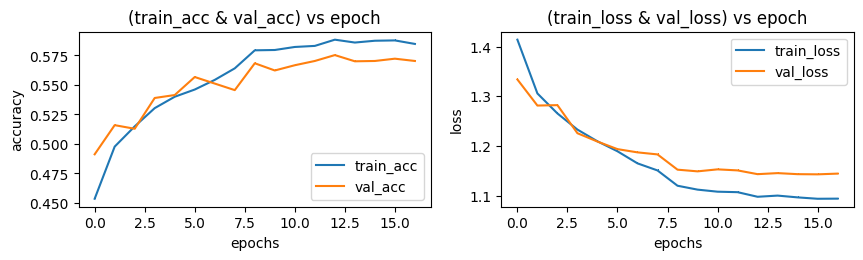

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [126]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    #plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['accuracy'],marker = ',',ms = 10, label = "train_acc")
    plt.plot(history.history['val_accuracy'], marker = ',', label = "val_acc")
    plt.title("(train_acc & val_acc) vs epoch")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],marker= ',', label = "train_loss")
    plt.plot(history.history['val_loss'], marker=',' , label = "val_loss")
    plt.title("(train_loss & val_loss) vs epoch")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    f = plt.figure()
    plt.show()
  


plot_accuracy_loss(model_history)
f = plt.figure()


In [121]:
model.save('/kaggle/working/EB0.h5')

In [122]:
model_1 = tensorflow.keras.models.load_model('/kaggle/working/EB0.h5')

In [123]:
evaluation = model_1.evaluate(validation_set)

# Print the evaluation metrics
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.5773 - loss: 1.1382 - mean_squared_error: 0.0945
Loss: 1.1433569192886353
Accuracy: 0.5753538608551025


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step


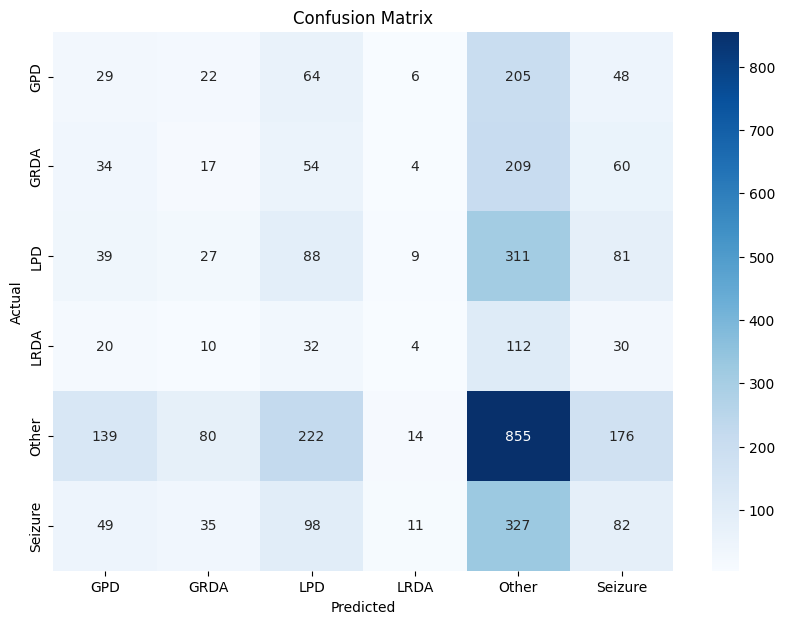

In [124]:

predictions = model_1.predict(validation_set)
predicted_classes = np.argmax(predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(validation_set.labels, predicted_classes)


labels = list(validation_set.class_indices.keys())
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [125]:
print(classification_report(validation_set.labels, predicted_classes, target_names=list(validation_set.class_indices.keys())))

              precision    recall  f1-score   support

         GPD       0.09      0.08      0.08       374
        GRDA       0.09      0.04      0.06       378
         LPD       0.16      0.16      0.16       555
        LRDA       0.08      0.02      0.03       208
       Other       0.42      0.58      0.49      1486
     Seizure       0.17      0.14      0.15       602

    accuracy                           0.30      3603
   macro avg       0.17      0.17      0.16      3603
weighted avg       0.25      0.30      0.27      3603



In [130]:
balanced_acc = balanced_accuracy_score(validation_set.labels, predicted_classes)
print("Balanced accuracy: ", balanced_acc)

Balanced accuracy:  0.1686476209050023


Hybrid Model

In [135]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization  
layer = tf.keras.layers.Dropout(0.30)

def Hybrid_model(input_shape, output_classes):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X_shortcut = X
    X = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Stage 2
    X_shortcut = Conv2D(64, kernel_size=(1, 1), strides=(2, 2), padding='valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = Add()([X, X_shortcut])
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Stage 3
    X_shortcut = Conv2D(128, kernel_size=(1, 1), strides=(2, 2), padding='valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    X = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = Add()([X, X_shortcut])
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Stage 4
    X_shortcut = Conv2D(256, kernel_size=(1, 1), strides=(2, 2), padding='valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    X = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = Add()([X, X_shortcut])
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Stage 5
    X_shortcut = Conv2D(512, kernel_size=(1, 1), strides=(2, 2), padding='valid', kernel_initializer='glorot_uniform')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)
    X = Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer='glorot_uniform')(X)
    X = Add()([X, X_shortcut])
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # Flatten
    X = Flatten()(X)

    # Fully Connected Layers
    X = Dense(1024, activation='relu', kernel_initializer='glorot_uniform')(X)
    X = Dense(output_classes, activation='softmax')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='CNN_model_with_skip_connections')
    
    return model

# Example usage
input_shape = (256, 256, 3)  
output_classes = 6  
model = Hybrid_model(input_shape, output_classes)
model.summary()


NameError: name 'ZeroPadding2D' is not defined